In [72]:

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch
if torch.cuda.is_available():
        device = torch.device('cuda')

print(device)
import numpy as np

import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import importlib
import sys

import random
from sklearn.model_selection import KFold
# 캐싱된 모듈 삭제
if 'models' in sys.modules:
    del sys.modules['models']
if 'Segdataset' in sys.modules:
    del sys.modules['Segdataset']
if 'utils' in sys.modules:
    del sys.modules['utils']
from models import CNN , RNN, Transformer
from Segdataset import SegDataset,read_train_file_list
from torch.utils.data import DataLoader

cuda


In [73]:
class Args:
    def __init__(self):
        self.data_root = '/workspace/dataset/tess_datasets/train/train_data'
        self.save_root = 'checkpoints/RNN'
        self.epoch = 50
        self.lr = 3e-4
        self.batch_size = 32
        self.num_workers = 8
        self.random_seed = 1
        self.n_mfcc = 16
        self.n_splits = 5
        self.model_kind = 'rnn'

opt = Args()


In [74]:
def main():
    print("Training by RNN")

    # 저장 디렉토리 없으면 생성
    if not os.path.exists(opt.save_root):
        os.makedirs(opt.save_root)
        print('Created directory:', opt.save_root)

    # 데이터셋 로딩
    mfcc_list, emotion_list = read_train_file_list(root=opt.data_root, n_mfcc=opt.n_mfcc)

    # KFold cross-validation
    kf = KFold(n_splits=opt.n_splits, shuffle=True, random_state=opt.random_seed)

    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')

    print(f"Using device: {device}")

    all_train_epoch_loss = []
    all_test_epoch_loss = []
    all_test_epoch_accuracy_emotion = []

    return kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion


In [75]:
def plot_fold_performance(train_losses, val_losses, val_accuracies, fold):
    # Fold별로 그래프를 그리기 (Colab에서 바로 확인 가능하도록)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [76]:
def train_and_validate(kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion):
    for fold, (train_idx, val_idx) in enumerate(kf.split(mfcc_list)):
        print(f"Fold {fold + 1}/{opt.n_splits}")

        # 모델을 fold마다 초기화
        model = RNN().to(device)

        # 학습/검증 데이터로 쪼개기
        train_mfcc = [mfcc_list[i] for i in train_idx]
        train_emotion = [emotion_list[i] for i in train_idx]
        val_mfcc = [mfcc_list[i] for i in val_idx]
        val_emotion = [emotion_list[i] for i in val_idx]

        train_set = SegDataset(train_mfcc, train_emotion)
        val_set = SegDataset(val_mfcc, val_emotion)

        # Create dataloaders
        train_loader = DataLoader(train_set, batch_size=opt.batch_size, shuffle=True, drop_last=True, num_workers=opt.num_workers)
        val_loader = DataLoader(val_set, batch_size=opt.batch_size, shuffle=False, drop_last=True, num_workers=opt.num_workers)

        # 각 fold에 따라 pos_weight 동적으로 설정
        num_pos = sum(em == 1 for em in train_emotion)
        num_neg = sum(em == 0 for em in train_emotion)
        pos_weight = torch.tensor([num_neg / num_pos]).to(device) if num_pos > 0 else torch.tensor([1.0]).to(device)

        # loss and optimizer 선언
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
        optimizer = optim.Adam(model.parameters(), lr=opt.lr)

        # 현재 폴드 값들 저장
        train_losses = []
        val_losses = []
        val_accuracies = []

        best_val_loss = float('inf')
        best_epoch = 0

        for epo in range(opt.epoch):
            model.train()
            train_loss = 0

            for index, (mfcc, emotion) in enumerate(train_loader):
                mfcc, emotion = mfcc.to(device), emotion.to(device)
                optimizer.zero_grad()
                output_emotion = model(mfcc)

                emotion = emotion.float()
                loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # 검증
            model.eval()
            val_loss = 0
            correct_emotion = 0
            total = 0
            with torch.no_grad():
                for mfcc, emotion in val_loader:
                    mfcc, emotion = mfcc.to(device), emotion.to(device)
                    output_emotion = model(mfcc)
                    emotion = emotion.float()

                    loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                    val_loss += loss.item()

                    predicted_emotion = (torch.sigmoid(output_emotion[:, 0]) > 0.56).float()
                    correct_emotion += (predicted_emotion == emotion).sum().item()
                    total += emotion.size(0)

            val_accuracy = correct_emotion / total
            print(f"Fold {fold + 1} | Epoch {epo} | Train Loss: {train_loss / len(train_loader)} | Val Loss: {val_loss / len(val_loader)} | Val Accuracy: {val_accuracy}")

            # 모델 저장
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epo
                torch.save(model.state_dict(), os.path.join(opt.save_root, f'fold_{fold + 1}_best_epoch.pth'))

            # Track the training and validation losses and accuracies for plotting later
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_accuracy)

        print(f"Fold{fold+1} best epoch : {best_epoch} ")

        all_train_epoch_loss.append(train_losses)
        all_test_epoch_loss.append(val_losses)
        all_test_epoch_accuracy_emotion.append(val_accuracies)

        plot_fold_performance(train_losses, val_losses, val_accuracies, fold)

    return all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion


Training by RNN
Using device: cuda
Fold 1/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 1 | Epoch 0 | Train Loss: 0.6272995269724301 | Val Loss: 0.5945268017905099 | Val Accuracy: 0.38169642857142855
Fold 1 | Epoch 1 | Train Loss: 0.6121650881000927 | Val Loss: 0.5929245437894549 | Val Accuracy: 0.3794642857142857
Fold 1 | Epoch 2 | Train Loss: 0.5896123200654984 | Val Loss: 0.5397434490067619 | Val Accuracy: 0.8839285714285714
Fold 1 | Epoch 3 | Train Loss: 0.5441259683242866 | Val Loss: 0.5023953935929707 | Val Accuracy: 0.9196428571428571
Fold 1 | Epoch 4 | Train Loss: 0.5082359133022172 | Val Loss: 0.46205767350537436 | Val Accuracy: 0.9486607142857143
Fold 1 | Epoch 5 | Train Loss: 0.48803666287234854 | Val Loss: 0.45966068123068127 | Val Accuracy: 0.9397321428571429
Fold 1 | Epoch 6 | Train Loss: 0.47748130400265965 | Val Loss: 0.43910942545958925 | Val Accuracy: 0.9776785714285714
Fold 1 | Epoch 7 | Train Loss: 0.47472177711980684 | Val Loss: 0.437469

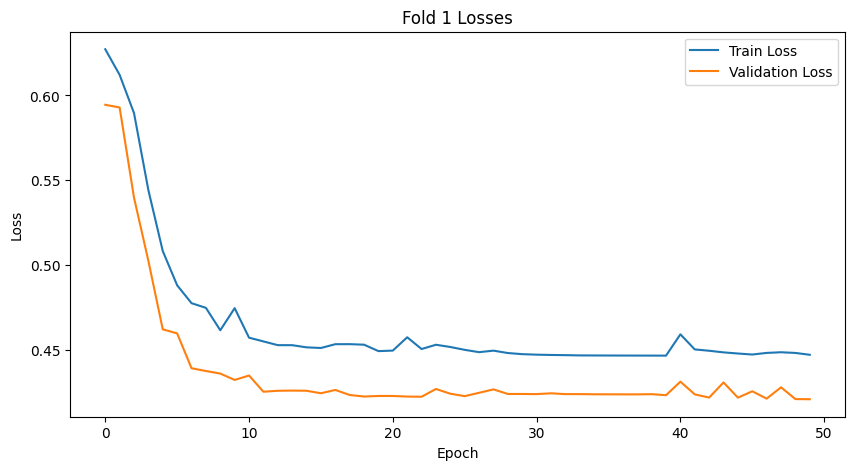

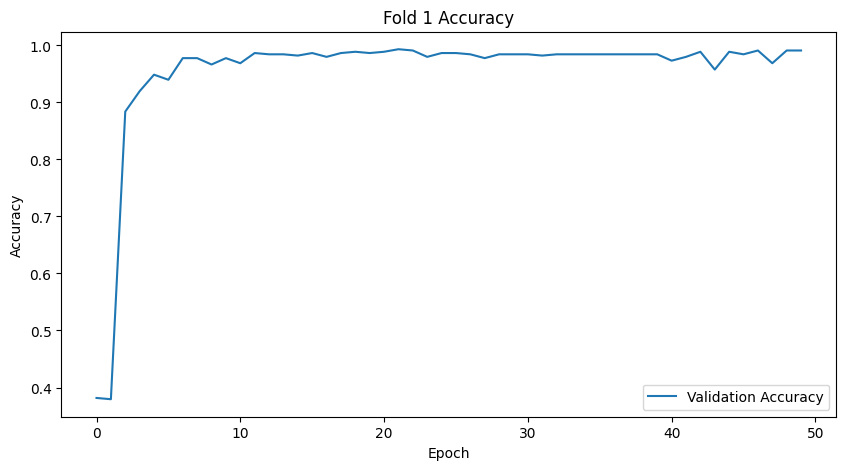

Fold 2/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 2 | Epoch 0 | Train Loss: 0.6067603762660708 | Val Loss: 0.6045686474868229 | Val Accuracy: 0.5535714285714286
Fold 2 | Epoch 1 | Train Loss: 0.5874492547341755 | Val Loss: 0.584640064409801 | Val Accuracy: 0.5290178571428571
Fold 2 | Epoch 2 | Train Loss: 0.5367204243583339 | Val Loss: 0.5066062488726207 | Val Accuracy: 0.921875
Fold 2 | Epoch 3 | Train Loss: 0.5023922063410282 | Val Loss: 0.4928059620516641 | Val Accuracy: 0.8839285714285714
Fold 2 | Epoch 4 | Train Loss: 0.4799194538167545 | Val Loss: 0.46609231191022055 | Val Accuracy: 0.9598214285714286
Fold 2 | Epoch 5 | Train Loss: 0.47312808462551664 | Val Loss: 0.5525030280862536 | Val Accuracy: 0.609375
Fold 2 | Epoch 6 | Train Loss: 0.5400225876697472 | Val Loss: 0.5658684117453439 | Val Accuracy: 0.5446428571428571
Fold 2 | Epoch 7 | Train Loss: 0.5139376095363072 | Val Loss: 0.48594541421958376 | Val Accuracy: 0.9285714285714286
Fold 2 | Epoch

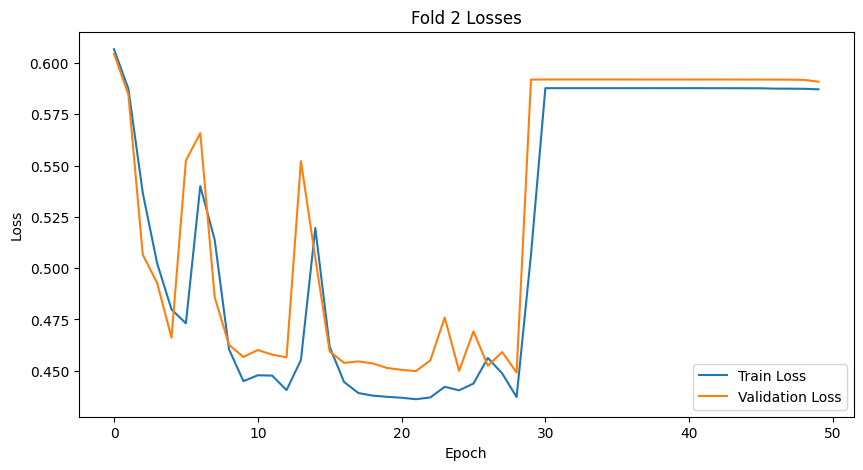

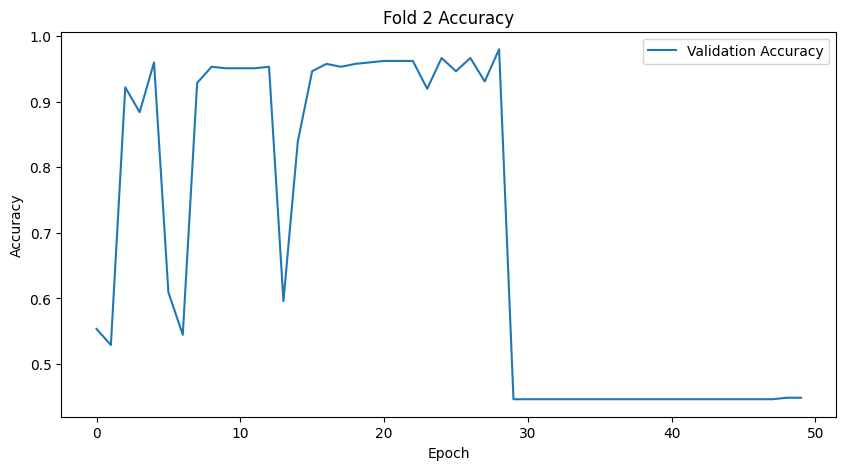

Fold 3/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 3 | Epoch 0 | Train Loss: 0.6023655767951693 | Val Loss: 0.6074170257364001 | Val Accuracy: 0.5334821428571429
Fold 3 | Epoch 1 | Train Loss: 0.5817713780062539 | Val Loss: 0.5908199846744537 | Val Accuracy: 0.5825892857142857
Fold 3 | Epoch 2 | Train Loss: 0.5616053933543819 | Val Loss: 0.553987273148128 | Val Accuracy: 0.7232142857142857
Fold 3 | Epoch 3 | Train Loss: 0.5258550393794265 | Val Loss: 0.5721427415098462 | Val Accuracy: 0.7723214285714286
Fold 3 | Epoch 4 | Train Loss: 0.5045075986002173 | Val Loss: 0.5383644316877637 | Val Accuracy: 0.7924107142857143
Fold 3 | Epoch 5 | Train Loss: 0.5023449371967997 | Val Loss: 0.5317967087030411 | Val Accuracy: 0.8348214285714286
Fold 3 | Epoch 6 | Train Loss: 0.4710854393030916 | Val Loss: 0.48391213374478476 | Val Accuracy: 0.9464285714285714
Fold 3 | Epoch 7 | Train Loss: 0.45377596095204353 | Val Loss: 0.4936126789876393 | Val Accuracy: 0.895089285714

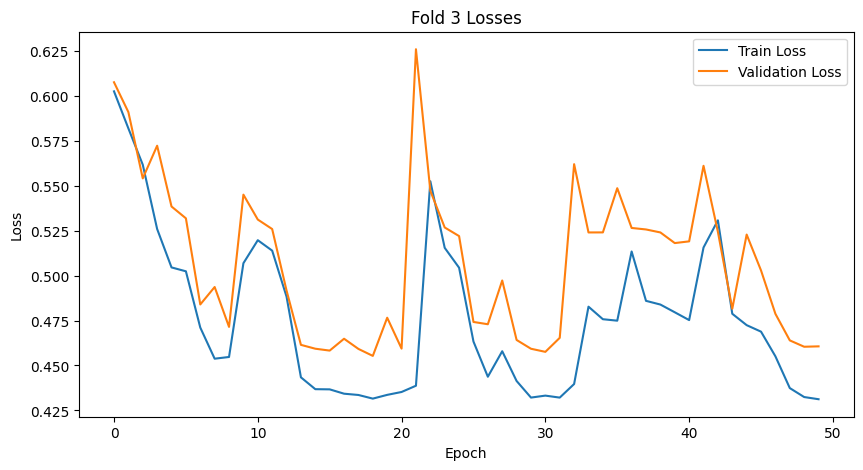

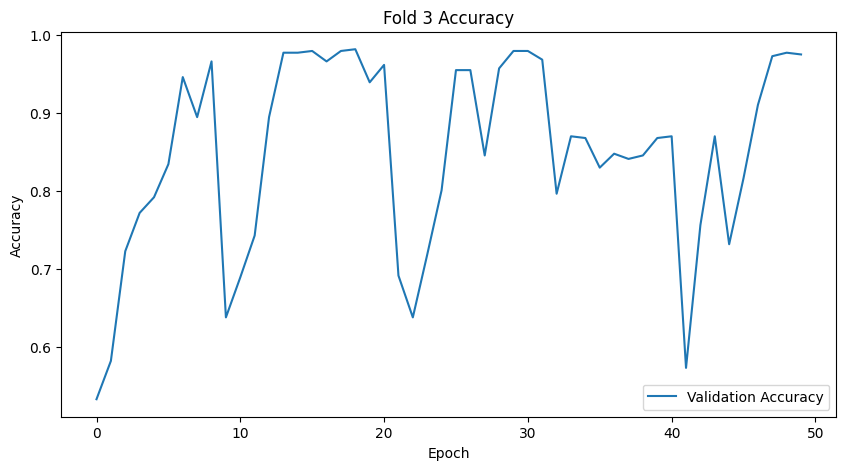

Fold 4/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 4 | Epoch 0 | Train Loss: 0.614167391189507 | Val Loss: 0.6096405982971191 | Val Accuracy: 0.5669642857142857
Fold 4 | Epoch 1 | Train Loss: 0.5981861352920532 | Val Loss: 0.5956060843808311 | Val Accuracy: 0.4330357142857143
Fold 4 | Epoch 2 | Train Loss: 0.5926393408860479 | Val Loss: 0.5893770286015102 | Val Accuracy: 0.48660714285714285
Fold 4 | Epoch 3 | Train Loss: 0.5480829823229995 | Val Loss: 0.5373443386384419 | Val Accuracy: 0.875
Fold 4 | Epoch 4 | Train Loss: 0.5035533580396857 | Val Loss: 0.5071230232715607 | Val Accuracy: 0.828125
Fold 4 | Epoch 5 | Train Loss: 0.5050859914294311 | Val Loss: 0.502538508602551 | Val Accuracy: 0.8370535714285714
Fold 4 | Epoch 6 | Train Loss: 0.4986670772944178 | Val Loss: 0.4672607694353376 | Val Accuracy: 0.9263392857142857
Fold 4 | Epoch 7 | Train Loss: 0.5379717828971999 | Val Loss: 0.5601128957101277 | Val Accuracy: 0.7857142857142857
Fold 4 | Epoch 8 | T

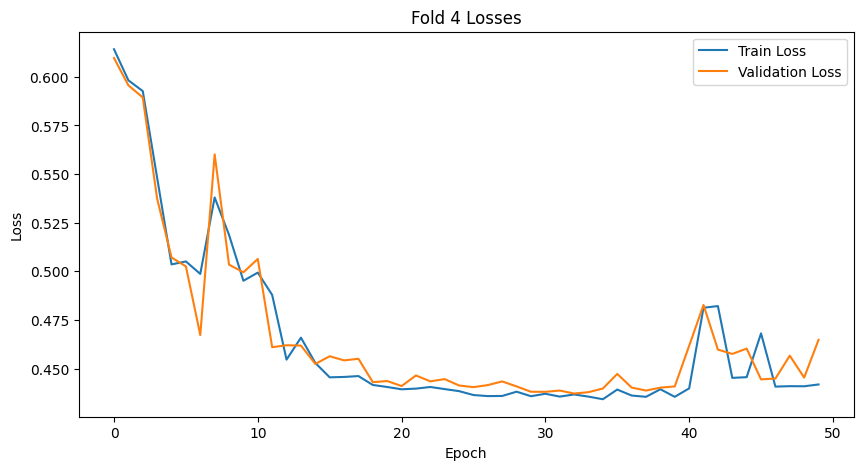

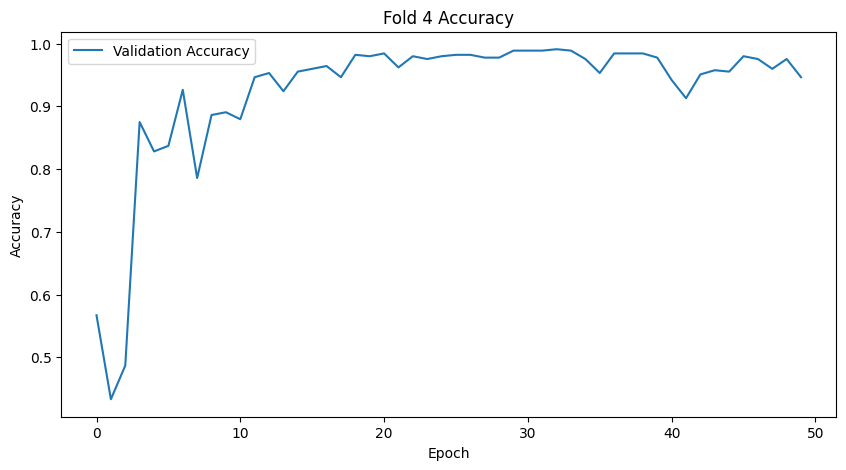

Fold 5/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 5 | Epoch 0 | Train Loss: 0.6200718799872058 | Val Loss: 0.6008016381944928 | Val Accuracy: 0.5825892857142857
Fold 5 | Epoch 1 | Train Loss: 0.6006353050470352 | Val Loss: 0.5943622759410313 | Val Accuracy: 0.4174107142857143
Fold 5 | Epoch 2 | Train Loss: 0.573840143425124 | Val Loss: 0.5457700618675777 | Val Accuracy: 0.8303571428571429
Fold 5 | Epoch 3 | Train Loss: 0.526932418346405 | Val Loss: 0.5067772673709052 | Val Accuracy: 0.9084821428571429
Fold 5 | Epoch 4 | Train Loss: 0.4931101511631693 | Val Loss: 0.4729307698351996 | Val Accuracy: 0.953125
Fold 5 | Epoch 5 | Train Loss: 0.47918172659618513 | Val Loss: 0.4672538446528571 | Val Accuracy: 0.953125
Fold 5 | Epoch 6 | Train Loss: 0.4715235893215452 | Val Loss: 0.45123582652636934 | Val Accuracy: 0.9642857142857143
Fold 5 | Epoch 7 | Train Loss: 0.46427205417837414 | Val Loss: 0.4674509572131293 | Val Accuracy: 0.890625
Fold 5 | Epoch 8 | Train 

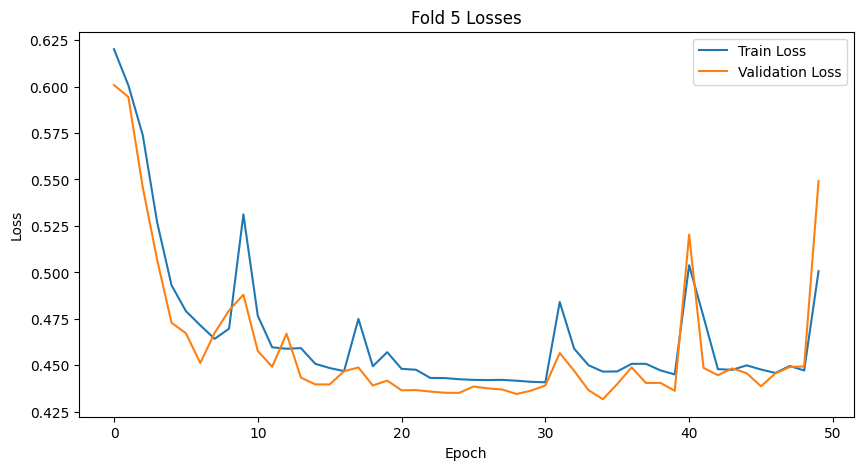

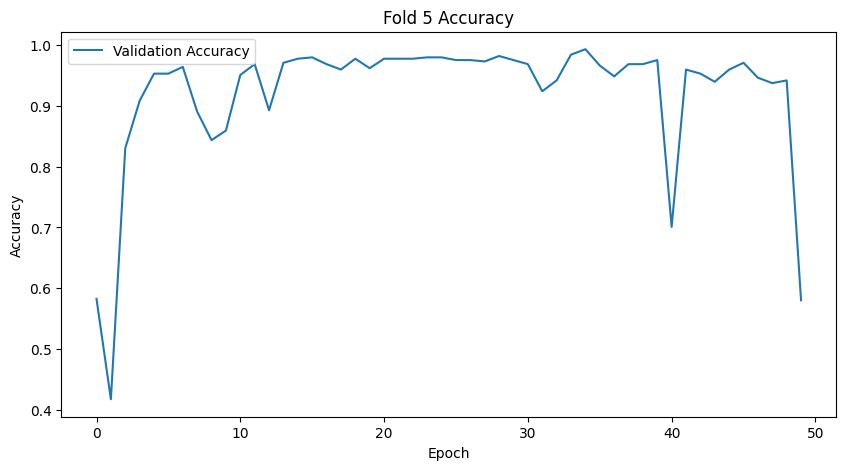

In [77]:
if __name__ == '__main__':
    kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion = main()
    train_and_validate(kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion)